# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 5 - Clustering and Reinforcement Learning




**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Homework 5 is due 4/3  (This is individual homework - No collaboration)

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- Problem 1 + Problem 2 = 75 points ; Problem 3 = 25 points
- To install `gym` package - please use `pip install gym`
- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
# RUN THIS TO INSTALL PACKAGES
#!pip install gym
#! pip install rpy2
#r_utils.install_packages('ggplot2')
# r_utils.install_packages('stats')
# r_utils.install_packages('factoextra')
# r_utils.install_packages('base')
# r_utils.install_packages('cluster')

In [3]:
# This can make the kernel die if it doesn't go well

# RUN THIS ON JUPYTER HUB
import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

import pandas as pd
from rpy2.robjects.packages import importr
r_utils = importr('utils')
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
r_ggplot2 = importr('ggplot2')
import IPython
import rpy2
from rpy2.robjects.lib.grdevices import render_to_bytesio
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import rpy2.robjects.lib.ggplot2 as ggplot2
r_stats = importr('stats')
r_factoextra = importr('factoextra')
r_cluster = importr('cluster')
r_base = importr('base')
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:67: UserWarning: This was designed againt ggplot2 version 2.2.1 but you have 3.1.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


In [4]:
#RL
import gym
from gym.envs.registration import register
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
#from tqdm import tqdm
from copy import deepcopy
import numpy.linalg as LA

Using TensorFlow backend.


Note that this has been tested on JupyterHub

Note that this has been tested with 
* pandas version 0.23.4
* rpy2 version 2.9.4
* ggplot2 version 2.2.1

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.


<hr style="height:2pt">

<div class="theme">*Handy* Algorithms </div>


    
In this assignment, you will be working with data collected from a motion capture camera system. The system was used to record 14 different users performing 5 distinct hand postures with markers attached to a left-handed glove. A set of markers on the back of the glove was used to establish a local coordinate system for the hand, and 8 additional markers were attached to the thumb and fingers of the glove. A total of 24 features were collected based on observations from the camera system. Two other variables in the dataset were the ID of the user and the posture that the user made.

These data have been preprocessed, including transformation to the local coordinate system of the record, removal of outliers, and removal of missing data.

The dataset `postures_clean.csv` contains 38,943 rows and 26 columns. Each row corresponds to a single frame as captured by the camera system. The data are represented in the following manner:

`Class (type: Integer). The hand posture of the given observation, with`

`1 = Fist (with thumb out)`

`2 = Stop (hand flat)`

`3 = Point1 (point with index finger)`

`4 = Point2 (point with index and middle fingers)`

`5 = Grab (fingers curled as if to grab)`

`User (type: Integer). The ID of the user that contributed the record.`

`X0, Y0, Z0, X1, Y1, Z1,..., X7, Y7, Z7 (type: Real). The x-coordinate, y-coordinate, and z-coordinate of the eight unlabeled marker positions.`


Start by reading the dataset into a pandas data frame.

In [5]:
#your code here
postures_df = pd.read_csv('data/postures_clean.csv')
postures_df.head(10)

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
0,1,0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,...,-47.909511,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124
1,1,0,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,...,-25.243914,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553
2,1,0,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,...,-67.660208,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279
3,2,0,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,...,-74.307346,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147
4,2,0,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,...,-71.629823,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243
5,2,0,80.775150,93.705283,-5.090904,63.479609,98.429524,11.161413,48.924111,154.340338,...,1.487330,95.261862,73.719164,-74.222778,20.499495,132.863377,35.309544,58.297882,27.583892,-71.888449
6,2,0,80.618164,93.781461,-5.012812,63.213130,98.462919,11.045095,48.777435,154.327283,...,22.984485,93.073910,137.215156,1.859117,83.404493,151.744359,16.542773,95.314840,73.900253,-73.894505
7,2,0,79.870413,93.921192,-5.628231,79.239570,55.197852,-72.374008,48.446947,154.215388,...,23.142914,96.293636,74.093419,-72.683063,83.279689,151.629068,16.999059,58.050614,27.980287,-72.379748
8,2,0,79.047726,55.438751,-72.559546,83.598699,151.459461,17.853364,96.926380,74.206724,...,-5.061439,62.309617,98.518498,10.364931,13.072035,94.721383,30.953311,48.975880,154.059457,33.309698
9,2,0,78.772453,55.731455,-72.850496,35.652032,99.280239,24.241786,84.010330,151.315526,...,10.920971,20.944487,132.294274,37.455166,79.983362,93.859173,-5.008803,12.893935,94.621584,30.972233


<div class='exercise'>Problem 1: Clustering with k-means </div>

(a) After appropriate pre-processing run the k-means clustering algorithm, using the function `r_stats.kmeans`, with the number of clusters corresponding to the number of users, `n_start` of 46, and 109 as the random seed. Add the result as a new column called `Cluster14` to your data frame.

In [6]:
num_cols = list(set(postures_df.columns)^set(['User', 'Class']))
scaler = StandardScaler()
scaler.fit(postures_df[num_cols])
postures_df[num_cols] = scaler.transform(postures_df[num_cols])

In [7]:
postures_df.describe()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
count,38943.000000,38943.000000,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,...,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04,3.894300e+04
mean,3.533986,8.149501,2.015467e-16,-6.143673e-17,3.177405e-16,-3.673090e-17,-1.722196e-16,-3.843577e-16,1.415981e-16,-4.217610e-17,...,-2.843509e-16,-2.246304e-16,-6.313016e-17,-5.918310e-17,2.033256e-16,2.352286e-16,4.820004e-17,-3.537373e-16,3.806226e-17,-2.299430e-16
std,1.332452,4.587195,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,...,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,1.000000,0.000000,-4.694604e+00,-4.008081e+00,-2.897060e+00,-4.591056e+00,-4.280510e+00,-2.981429e+00,-4.021164e+00,-4.328281e+00,...,-3.897916e+00,-3.892005e+00,-3.964616e+00,-2.786468e+00,-3.868486e+00,-3.930792e+00,-3.834036e+00,-3.988469e+00,-3.788264e+00,-2.750580e+00
25%,2.000000,5.000000,-6.816268e-01,-4.683485e-01,-7.045392e-01,-7.465208e-01,-4.591004e-01,-7.005436e-01,-7.917207e-01,-4.283223e-01,...,-7.507012e-01,-7.962230e-01,-4.256776e-01,-7.650950e-01,-8.006432e-01,-5.450102e-01,-7.645590e-01,-8.177120e-01,-6.153022e-01,-7.455857e-01
50%,4.000000,9.000000,9.405094e-02,5.421821e-03,1.119439e-01,1.236075e-01,-1.412148e-02,1.406046e-01,1.305839e-01,-3.437901e-03,...,1.017765e-01,1.284899e-01,9.422165e-02,8.749071e-02,1.269402e-01,1.173988e-01,8.094412e-02,1.338694e-01,1.316695e-01,2.769013e-02
75%,5.000000,12.000000,7.630939e-01,9.262373e-01,7.706813e-01,7.707507e-01,9.060965e-01,7.495502e-01,7.694198e-01,8.925195e-01,...,7.818011e-01,7.645879e-01,8.440873e-01,7.908744e-01,7.817031e-01,8.012004e-01,7.950059e-01,8.144890e-01,7.586037e-01,7.942627e-01
max,5.000000,14.000000,3.212762e+00,1.878843e+00,3.782635e+00,3.153848e+00,1.916695e+00,3.507823e+00,3.217900e+00,1.890431e+00,...,3.867896e+00,3.643059e+00,1.877687e+00,3.652172e+00,3.493647e+00,1.932999e+00,3.957657e+00,3.771913e+00,1.991564e+00,4.071018e+00


### Solution 1(a)

In [8]:
#your code here
py_df = postures_df[num_cols]
clusters = len(postures_df['User'].unique())

random.seed(109)
km_out14 = r_stats.kmeans(py_df, centers=clusters, nstart=46)
display(km_out14)
display(list(km_out14.names))

R object with classes: ('kmeans',) mapped to:
<ListVector - Python:0x7f7191f84ac8 / R:0x55fecbe542f8>
[IntVector, Matrix, FloatVector, FloatVector, ..., FloatVector, IntVector, IntVector, IntVector]
  cluster: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f71ebfe2708 / R:0x55feca959960>
[2, 2, 13, 13, ..., 12, 12, 12, 12]
  centers: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f7235337508 / R:0x55fec60d5aa0>
[0.116824, -0.269727, -0.961542, 0.054954, ..., -0.533891, -0.146370, 0.372653, 0.274979]
  totss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7191f84748 / R:0x55fecbe3cc70>
[934632.000000]
  withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7191f84788 / R:0x55fecbe53118>
[28976.176008, 55679.830690, 43398.617444, 30819.199452, ..., 54535.889749, 64357.935983, 40862.744452, 53111.593859]
  tot.withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f71926e8f88 / R:0x55fecbe58a30>
[647475.782179]
  betweenss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7191f84608 / R:0x55fecbe3cca8>
[287156.217821]
  size: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f7191f84148 / R:0x55fec55c57b8>
[1,706, 3,076, 2,462, 1,832, ..., 2,932, 4,384, 2,394, 3,172]
  iter: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f7191f84748 / R:0x55fecbe577d0>
[11]
  ifault: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f7191f846c8 / R:0x55fecbe575a0>
[2]

['cluster',
 'centers',
 'totss',
 'withinss',
 'tot.withinss',
 'betweenss',
 'size',
 'iter',
 'ifault']

In [9]:
postures_df['Cluster14'] = np.array(km_out14.rx2("cluster"))

(b) Now visualize the results for k-means on a random sample of 2,000 observations without replacement (setting 109 as the random seed when sampling), using the function `r_factoextra.fviz_cluster`. Does 14 clusters seem to make sense?

### Solution 1(b)

In [10]:
random.seed(109)
sample = np.random.choice(a=postures_df.index, size=2000, replace=False)
r_sample = rpy2.robjects.IntVector(sample+1)

In [11]:
df_dict = dict(py_df)
r_df = rpy2.robjects.DataFrame(df_dict)
r_sample_df = r_df.rx(r_sample, True)
r_sample_df

Z6,Z3,Y6,...,X5,Y1,Z2
-0.223433,0.086644,-0.139373,...,-0.130095,-1.428217,0.619745
-0.006533,0.034703,-0.065495,...,1.599721,1.448296,1.169659
-2.190506,-2.031180,-1.856828,...,-0.007790,-0.384766,-0.010995
0.980249,-0.767722,-0.121798,...,0.438825,1.250778,-0.930813
...,...,...,...,...,...,...
-1.648503,0.021454,-2.070427,...,1.169411,1.418141,0.934113
0.966355,0.143431,0.014117,...,-1.077981,-0.512404,1.195744
-0.150382,-0.637208,-2.456173,...,-0.453686,0.970848,-0.363865
-0.508529,-2.236277,0.193681,...,0.393037,0.841557,-2.117700


In [12]:
km_sample14 = km_out14.rx2('cluster').rx(r_sample)
km_sample14

12,3,6,1,...,3,8,6,10


In [13]:
#your code here
%load_ext rpy2.ipython

/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


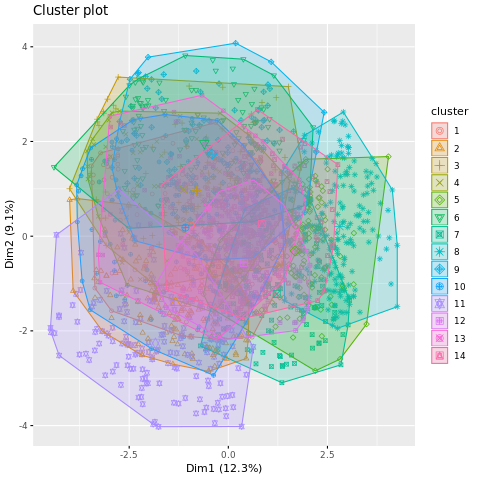

In [14]:
%%R -i km_sample14 -i r_sample_df
fviz_cluster(list(data=r_sample_df, cluster=km_sample14), geom='point')

**Answer:**
* We can see a lot of overlapping clusters. Even though we have 14 unique users, they are still doing the same hand postures. So it might be hard to find the subtle differences in the way different users do the same hand postures. 
* Some of the clusters stand out but we are taking just first two principal components of the  24 dimensions 
* Dim1 and Dim2 only capture a total of ~22% of the variation, which makes it harder to see all the clusters distinctly in a 2D plot.

(c) Compare the results from your clustering algorithm to the actual users for the entire dataset. To do this :

(i) calculate the Gini coefficient for each cluster, and also report the average Gini coefficient for the clustering method. For $K$ total labels, the Gini coefficient for each cluster is given by $$1 - \sum_{i=1}^K p_i^2,$$ where $p_i$ is the proportion of data point with label $i$ in the cluster (given that there are also $K$ clusters, e.g., 14 people and 14 clusters). 

(ii) calculate the entropy of each cluster, where entropy is defined as $$-\sum_{i=1}^K p_i \log p_i,$$ and also report the average entropy.

Hint: be careful, because r_stats.kmeans returns cluster numbers beginning with 1.

### Solution 1(c)(i)

In [15]:
gini = {}
p_i = {}
for i in postures_df['Cluster14'].unique():
    df_gb = postures_df[postures_df['Cluster14']==i].groupby(by='User')
    num = df_gb['User'].count()
    den = postures_df[postures_df['Cluster14']==i].shape[0]
    p_i[i] = num/den
    gini[i]= 1-np.sum(p_i[i]**2)

In [16]:
gini

{2: 0.8371565761015691,
 13: 0.902214461243613,
 4: 0.8931722078144964,
 9: 0.8963350023493575,
 14: 0.8913091616588402,
 7: 0.8092899528185667,
 5: 0.7922424908508998,
 1: 0.8854961936974391,
 10: 0.8999440126090641,
 11: 0.8104907228698149,
 3: 0.9048695327384035,
 6: 0.8895682559360949,
 8: 0.6846034843893931,
 12: 0.8353858714835634}

In [17]:
print("Average Gini Coefficient for 14 Clusters:")
print(np.mean(list(gini.values())))

Average Gini Coefficient for 14 Clusters:
0.8522912804686512


### Solution 1(c)(ii)

In [18]:
entropy = {}
for i in list(p_i.keys()):
    entropy[i] = -np.sum(p_i[i]*np.log(p_i[i]))

In [19]:
entropy

{2: 1.9995004613565883,
 13: 2.409319111751112,
 4: 2.3748723309373885,
 9: 2.370219739447099,
 14: 2.3330361428416264,
 7: 1.970138717660542,
 5: 1.9206640858149915,
 1: 2.3411704488744376,
 10: 2.3990023870540753,
 11: 1.9813674744447165,
 3: 2.434723194335792,
 6: 2.342072997894033,
 8: 1.4638560589354723,
 12: 2.000001877151192}

In [20]:
print("Average Entropy for 14 Clusters:")
np.mean(list(entropy.values()))

Average Entropy for 14 Clusters:


2.1671389306070763

(d) Repeat all of the above steps, but group by posture rather than by user. That is : 

(i) Run the k-means algorithm with 5 centroids instead of 14, creating a variable named `Cluster5` and adding it to the dataset. 

(ii) Visualize the results for k-means on a random sample of 2,000 observations without replacement (setting 109 as the random seed when sampling), using the function `r_factoextra.fviz_cluster`. Does 5 clusters seem to make sense?

(iii) Calculate the Gini coefficient for each cluster, and also report the average Gini coefficient.

(iv) Calculate the entropy of each cluster, and also report the average entropy. 


### Solution 1(d)

### (i)

In [21]:
#your code here  
clusters = len(postures_df['Class'].unique())
random.seed(109)
km_out5 = r_stats.kmeans(py_df, centers=clusters, nstart=46)
km_out5

R object with classes: ('kmeans',) mapped to:
<ListVector - Python:0x7f7191c5c248 / R:0x55fec64fa5c8>
[IntVector, Matrix, FloatVector, FloatVector, ..., FloatVector, IntVector, IntVector, IntVector]
  cluster: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f7191c4a6c8 / R:0x55fecf959060>
[1, 4, 3, 3, ..., 4, 1, 4, 4]
  centers: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f723406f148 / R:0x55fec403b0b0>
[-0.165167, -0.038387, -0.566382, -0.133854, ..., -1.249271, 0.347113, -0.355141, 0.800016]
  totss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7191f84548 / R:0x55fed3a315f8>
[934632.000000]
  withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7191f841c8 / R:0x55fed0b18148>
[151755.367002, 142339.858833, 134098.021848, 169667.903151, 159043.847504]
  tot.withinss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7191c11348 / R:0x55fed3a41358>
[756904.998338]
  betweenss: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7191c11e88 / R:0x55fed3a31630>
[177727.001662]
  size: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f7191c1b048 / R:0x55fec5b65c78>
[7,683, 6,706, 6,475, 8,593, 9,486]
  iter: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f7191c11f88 / R:0x55fed3a41240>
[5]
  ifault: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7f7191c1b108 / R:0x55fed3a41160>
[0]

In [22]:
#your code here
postures_df['Cluster5'] = np.array(km_out5.rx2("cluster"))

### (ii)

In [23]:
#your code here
km_sample5 = km_out5.rx2('cluster').rx(r_sample)
km_sample5

4,3,1,2,...,3,5,2,2


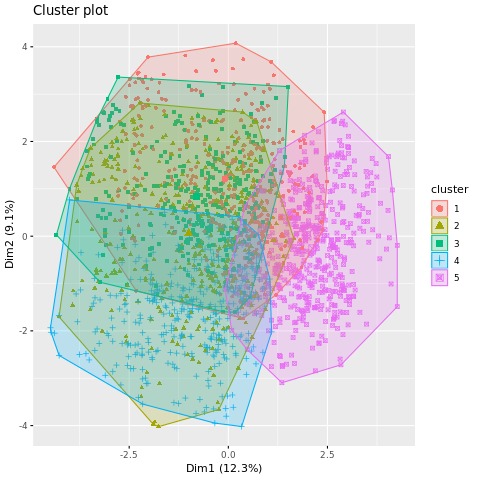

In [24]:
%%R -i km_sample5 -i r_sample_df
fviz_cluster(list(data=r_sample_df, cluster=km_sample5), geom='point')

**Answer:**
* 5 Clusters seem to make more sense compared to 14 due the fact that we can see `Cluster 4` and `Cluster 5` stand out from the rest. `Cluster 1`, `Cluster 2` and `Cluster 3` seem to be pretty much overlapping in the space of Dim1 and Dim2.
* However, just as before, the PCA components (Dim1 and Dim2) only explain ~22% of variation in the data -- so seeing all the clusters clearly is difficult.

### (iii)

In [25]:
gini = {}
p_i = {}
for i in postures_df['Cluster5'].unique():
    df_gb = postures_df[postures_df['Cluster5']==i].groupby(by='Class')
    num = df_gb['Class'].count()
    den = postures_df[postures_df['Cluster5']==i].shape[0]
    p_i[i] = num/den
    gini[i]= 1-np.sum(p_i[i]**2)

In [26]:
gini

{1: 0.7256138641800571,
 4: 0.30715462908010316,
 3: 0.7375335251412471,
 2: 0.7421574920910262,
 5: 0.27680227314583117}

In [27]:
np.mean(list(gini.values()))

0.557852356727653

### (iv)

In [28]:
entropy = {}
for i in list(p_i.keys()):
    entropy[i] = -np.sum(p_i[i]*np.log(p_i[i]))

In [29]:
entropy

{1: 1.331973686935903,
 4: 0.6267412078395436,
 3: 1.3661387689767899,
 2: 1.3732555810321425,
 5: 0.5481408708474245}

In [30]:
np.mean(list(entropy.values()))

1.0492500231263606

(e) What do the results suggest? Does this make sense in the context of what we know about the problem?

### Solution 1(e)

* We see that doing 5 clusters seems to give far better results (visualization, `gini coefficient` and `entropy`) compared to 14 clusters.
* Even though 5 clusters seem to be better than 14, we still get a fairly high `gini coefficient`
* This could be due to the fact that some of the postures could look very similar (execpt a few subtle differences). For example, the following postures look very similar to each other:

    - `Point1 (point with index finger)` and `Point2 (point with index and middle fingers)`
    - `Fist (with thumb out)` and `Grab (fingers curled as if to grab)`.


<div class='exercise'> <b> Problem 2: Clustering Evaluation and Hierarchical Clustering </b> </div>

In the previous problem, we examined the results of running k-means with 5 and 14 centroids on the postures data. In this problem, we will investigate various ways of evaluating the quality of a clustering assignment. For all of these questions, you can work with the sample of 2,000 data points obtained in the previous problem.

Hint: Use the function `r_factoextra.fviz_nbclust`.

(a) Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,15\}.$
 

### Solution 2(a)

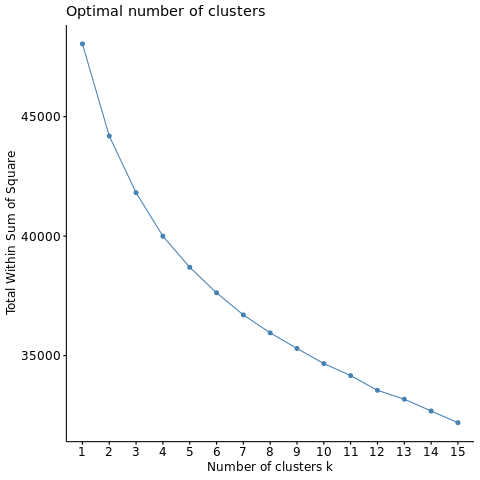

In [31]:
%%R -i r_sample_df
fviz_nbclust(r_sample_df, FUNcluster=kmeans, method="wss", k.max=15, nstart=46)

**Answer:**
* Within-cluster Sum of Squares (`wss`) gives us an elbow at 5. 
* This can be justified by the fact that the variation within each of the five postures will be the least, since the coordinates will be similar for different postures.
* Beyond that, the algorithm doesn't find any additional clusters that will significantly minimize the total sum of squares.


(b) Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,15\}$. Plot the results. 

### Solution 2(b)

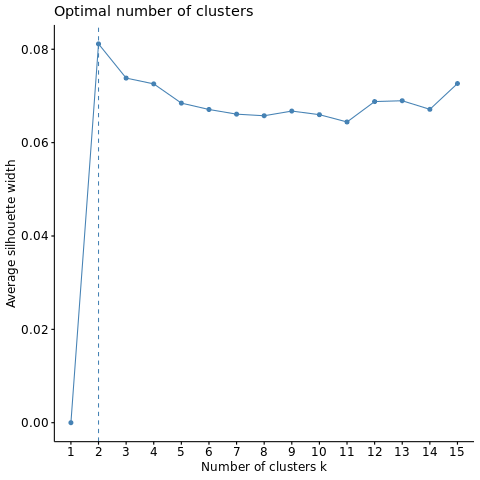

In [32]:
%%R -i r_sample_df
fviz_nbclust(r_sample_df, FUNcluster=kmeans, method="silhouette", k.max=15, nstart=46)

**Answer:**

* Using `silhoutte`, we get optimal number of clusters = 2.
* Here, we are looking at the average dissimilarity within cluster as well as that between points belonging to next closest cluster.
* As noted in `Solution 1(e)`, there are some postures that are very similar to each other except a few subtle differences. So the distance between the points belonging to similar postures is very close the average dissimilarity within cluster (for those clusters).

(c) Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Plot the results. 

### Solution 2(c)

Clustering k = 1,2,..., K.max (= 15): .. done
Bootstrapping, b = 1,2,..., B (= 100)  [one "." per sample]:
.................................................. 50 
.................................................. 100 


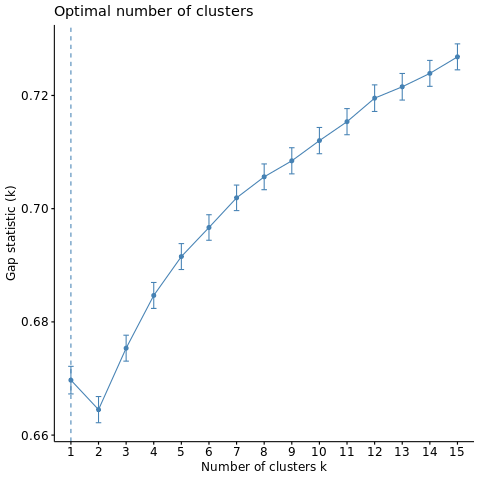

In [33]:
%%R -i r_sample_df
fviz_nbclust(r_sample_df, FUNcluster=kmeans, method="gap_stat", k.max=15, nstart=46)

**Answer:**

* Gap statistic is the difference in total within-cluster SS ($T_k$) between the uniformly generated data (no clustering) and the clustered data.
* We can see that Gap(K) improves significantly upto $K=8$.

(d) After analyzing the plots produced by all three of these measures, discuss the number of clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

### Solution 2(d)

* The optimal number of clusters for our dataset is $K=8$.
* **Reasoning:** 
    - Since the data is converted to the local coordinate system, the heights of the users wont be a contributing factor to the (X, Y, Z) coordinates thereby making it harder to spot differences between users purely based on hand/finger sizes.
    - $K=2$ can be deceptive because that will just group the similar hand postures together without being able to spot the subtle differences in the features of similar looking postures (like Class 3 and 4 or Class 1 and 5).
    - Even though we have 5 possible hand postures, there is still some variation that is not explained at $K=5$, based on the `gap_stat` plot above.
    - **Interestingly, this is also the number of markers we have used to gather the features.**

(e) Hierarchical clustering. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results.

### Solution 2(e)

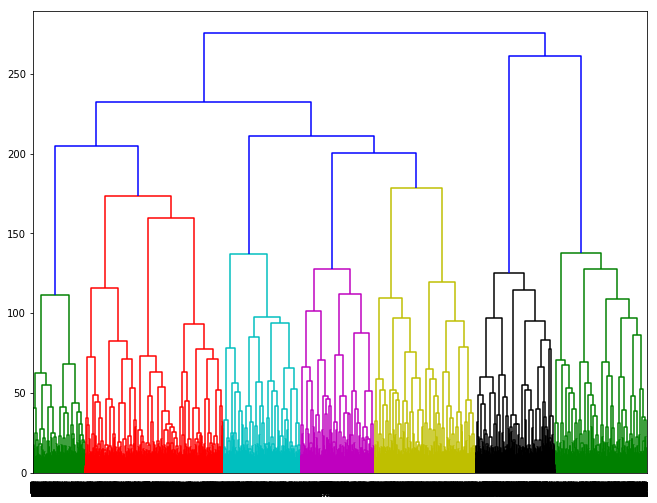

In [33]:
plt.figure(figsize=(11,8.5))
dist_mat = pdist(py_df, metric="euclidean")
ward_data = hac.ward(dist_mat)

hac.dendrogram(ward_data);

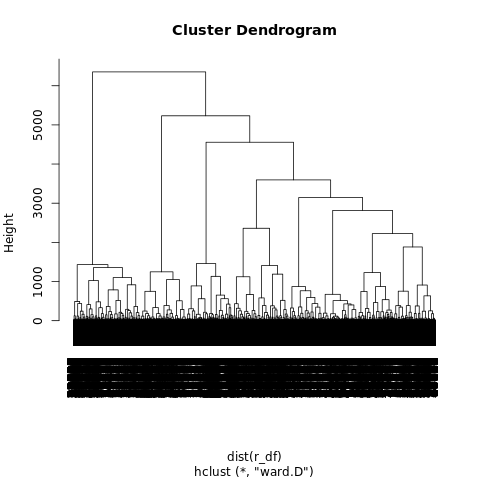

In [34]:
%%R -i r_df
stacked_cluster = hclust(dist(r_df), method = "ward.D")
plot(stacked_cluster)

**Answer:**

* Based on both the plots above, $K = 7$ or $K=8$ seems to be the optimal number of clusters.
* We can see how the height reduction is different for different sub-groups of clusters.

<div class='exercise'> <b> Problem 3: Model-Free TD Learning </b> </div>



In this assignment we are going to work with OpenAIgym's FrozenLake environment. The details of the environment can be found in the link https://gym.openai.com/envs/FrozenLake-v0/. 


Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. 

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:
[PP: WOULD IT BETTER TO INCLUDE A DIAGRAM]

- S: starting point, safe
- F: frozen surface, safe
- H: hole, fall to your doom
- G: goal, where the frisbee is located

SFFF  <br> 
FHFH <br> 
FFFH  <br> 
HFFG <br> 

Expected actions are Left(0), Down(1), Right(2), Up(3). 

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.


In [34]:
import gym
from gym.envs.registration import register
register(id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

In [35]:
from gym.envs.registration import register
register(
    id='FrozenLake8x8NotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '8x8', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

*hint:* If you receive an error message while registering the above env the second time you run this cell again, ignore the error message or restart the kernel. 

Throughout the assignment, use only the environments we registered in the previous cells:
- `FrozenLake8x8NotSlippery-v0`
- `FrozenLakeNotSlippery-v0` 

Even though the original problem description has slippery environment, we are working in a non-slippery environment. In our environment, if you go right, you only go right whereas in the original environment, if you intend to go right, you can go right, up or down with 1/3 probability.



### Demo Code to understand OpenAIGym

We will look at demo code on how to work with the environment - extremely straightforward. Here we are going to work with a random choice of action just to show you how to sample transitions from the environment. 

In [36]:
import gym
import numpy as np


#Change environment to FrozenLake8x8 to see grid.
#env = gym.make('FrozenLakeNotSlippery-v0')
env = gym.make('FrozenLake8x8NotSlippery-v0')

print(env.observation_space.n)


#Both the grids look like as follows.
'''
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]'''

#env.render() prints the frozenlake with an indicator showing where the agent is. You can use it for debugging.
env.render()

Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
################

num_episodes = 2000
rList = []

num_episodes = 1
max_iter_per_episode = 10
for i in range(num_episodes):
    iter = 0
            
    #Reset environment and get an initial state - should be done at start of each episode.
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    while iter < max_iter_per_episode:
        iter+=1
        #Choose an action
        a = np.random.choice(np.array([0,1,2,3]))
        
        # env.step() gives you next state, reward, done(whether the episode is over)
        # s1 - new state, r-reward, d-whether you are done or not
        s1,r,d,_ = env.step(a)
        print('State : ',s, ' Action : ', a, ' State 1 : ', s1, ' Reward : ',r, 'Done : ', d)
        
        if d:
            print('Episode Over')
            if r != 1:
                print('Fell into hole with reward ', r)            
            break
        s = s1
    

64

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
State :  0  Action :  0  State 1 :  0  Reward :  0.0 Done :  False
State :  0  Action :  1  State 1 :  8  Reward :  0.0 Done :  False
State :  8  Action :  0  State 1 :  8  Reward :  0.0 Done :  False
State :  8  Action :  2  State 1 :  9  Reward :  0.0 Done :  False
State :  9  Action :  2  State 1 :  10  Reward :  0.0 Done :  False
State :  10  Action :  0  State 1 :  9  Reward :  0.0 Done :  False
State :  9  Action :  2  State 1 :  10  Reward :  0.0 Done :  False
State :  10  Action :  2  State 1 :  11  Reward :  0.0 Done :  False
State :  11  Action :  3  State 1 :  3  Reward :  0.0 Done :  False
State :  3  Action :  2  State 1 :  4  Reward :  0.0 Done :  False


**3.1 Define the MDP [8 pts]**

1. Define the MDP using the information from the link provided for FrozenLake environment. Use standard notations wherever possible. Defining the MDP usually means that you formally define your state space, action space and reward space, the absorbing states and discounts.

2. Also justify why this problem is a MDP (i.e. justify the state representation and its corresponding Markovianity). 


### Solution 3.1.1
1. State Space: {S, F, H, G}
2. Action Space: {0, 1, 2, 3}
3. Reward Space: {0, 1} 
4. Absorbing States: 

### Solution 3.1.2
Reference: Lecture notes Slide 25
**Markov property:** "The future system dynamics from any state have to depend on this state only."

* In the given problem, we only require our current state to determine the best way to reach G. The previous states do not affect where we go next. Thus, the given problem is a MDP.

**3.2 Value and Policy Iteration [15 pts]**

The aim in this problem is to reach the goal from S to G. Let us assume that we know our transition model (right - one step right, left -one step left, up - one step up, down - one step down. If an action is not possible from a spot, you remain there) In these environments, reaching the goal (G) with fetch us a reward of +1 and terminate the episode. Reaching any Hole (H) would give us 0 reward and terminate the episode.

For both the environments (you can find the states of both the environments in the demo code above on the commented lines), do the following.

1. Write code to perform **value iteration** (starting from zero value assignment) and then, calculate optimal value function and thus calculate the subsequent policy induced by the value function. Show the value function and policy using heat map and arrow marks (to indicate direction) on each of the 4\*4 or 8\*8 grid cells.
2. Write code to perform **policy iteration** (starting from a zero policy) and then calculate the optimal policy. Show the same visualizations. Check if the policy matches in both the cases. Check if the value function matches in both the cases. Justify the results found on this comparison.
3. Can you try two or three different $\gamma$ values and also discuss what the impact of $\gamma$ is on your training.


### Solution 3.2

#### Define Functions

In [37]:
env.reset()
env.step(2)

(1, 0.0, False, {'prob': 1.0})

In [38]:
def set_environment(env_name='4x4'):
    """
    Set the environment by passing env_name: {'4x4', '8x8'}.
    
    Return Value:
    Environment from gym
    
    """
    
    if env_name == '4x4':
        env = gym.make('FrozenLakeNotSlippery-v0')
    elif env_name == '8x8': 
        env = gym.make('FrozenLake8x8NotSlippery-v0')
    
    print('Environment set to:')
    env.render()
    
    return(env)


def get_action_values(env, state, gamma):
    """
    Calculate the value for all action in a given state.

    Return Value:
        Best value at a given state.
    """
    
    n = env.observation_space.n
    A = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        p,s1,r,d = env.env.P[state][a][0]
        s1_row = (s1+1)%8+1
        s1_col = (s1+1)-8*((s1+1)%8)
        K = (n/4)-s1_row+s1_col
        
        if (d==1) & (r==0):
            A[a] = 0 
        else:
            A[a] = r + gamma**(K)
    return(A)


In [39]:
env_grid = {    "4x4": ["SFFF",
                        "FHFH",
                        "FFFH",
                        "HFFG"
                       ],
            "8x8": [
                "SFFFFFFF",
                "FFFFFFFF",
                "FFFHFFFF",
                "FFFFFHFF",
                "FFFHFFFF",
                "FHHFFFHF",
                "FHFFHFHF",
                "FFFHFFFG"
            ]
           }

def heatmap(policy, V, direction, grid=env_grid, title='Heatmap'):
    
    fig, ax = plt.subplots(1,1, figsize=(11, 9))
    ax = sns.heatmap(v)

    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]): 
            x = j+0.5
            y = i+0.5
            dx, dy = direction[policy[i,j]]
            ax.arrow(x, y, dx, dy, color='red', head_width=0.2, head_length=0.2)
            
            env_name = "%sx%s"%(policy.shape[0], policy.shape[1])
            text = env_grid[env_name][i][j]
            ax.text(x, y, s=text, fontsize=16, color="white")
            ax.set_title(title, fontsize=18)
    return(fig, ax)

### Solution 3.2.1: Value Iteration

In [40]:
def value_iteration(env_name, num_episodes, epsilon, gamma):
    """
    Value Iteration Algorithm.
        
    Return Value:
        (environment, optimal policy, optimal value function.)
    """
    
    env = set_environment(env_name)
    
    for i in range(num_episodes):
        
        # Find the value function for each state
        V = np.zeros(env.observation_space.n)
        V[-1] = 1
        while True:
            delta = 0
            
            for s in range(env.observation_space.n):
                A = get_action_values(env, s, gamma)
                best_value = np.max(A)
                delta = max(delta, np.abs(best_value - V[s]))
                V[s] = best_value
                
            if delta < epsilon:
                break

        # Find policy using optimal value function above
        policy = np.zeros([env.observation_space.n,env.action_space.n])
        for s in range(env.observation_space.n):
            A = get_action_values(env, s, gamma)
            best_action = np.argmax(A)
            policy[s, best_action] = 1.0
    
    policy = np.reshape(np.argmax(policy, axis=1), (env.env.nrow, env.env.ncol))
    V = V.reshape(env.env.nrow, env.env.ncol)
    
    return(env, policy, V)

Environment set to:

SFFF
FHFH
FFFH
HFFG

Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)

Policy:
[[1 2 1 2]
 [0 0 3 0]
 [3 1 3 0]
 [0 2 1 0]]

Value Function:
[[ 49.32046366   9.13918149 266.16258127  21.23084239]
 [ 49.32046366   0.           9.13918149   0.        ]
 [ 49.32046366  49.32046366 266.16258127   0.        ]
 [  0.         114.57426377 114.57426377   0.        ]]



(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71905e5c88>)

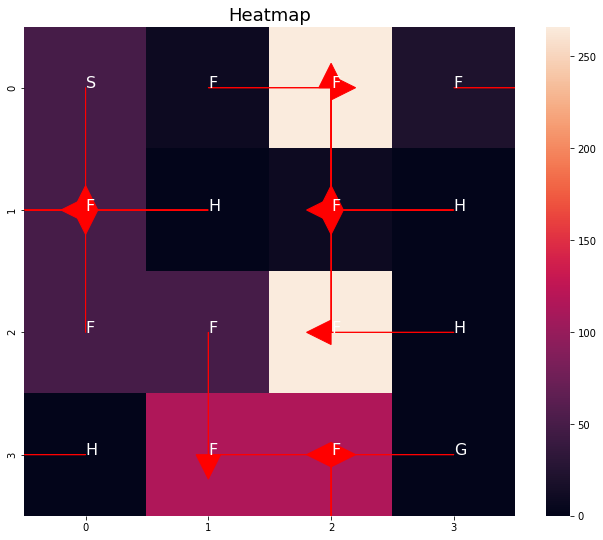

In [41]:
# Set learning parameters
num_episodes = 1000
epsilon = 0.0001
gamma = 0.9
dir_mapper = {0: (-1, 0), 1:(0,1), 2: (1,0), 3: (0,-1)}

curr_env, policy, v = value_iteration(env_name='4x4', num_episodes=num_episodes, epsilon=epsilon, gamma=gamma)

print("")
print("Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)")
print("")

print("Policy:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

heatmap(policy=policy, V=v, direction=dir_mapper)

Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)

Policy:
[[2 2 2 2 2 2 3 0]
 [2 2 2 2 2 2 3 0]
 [2 2 3 0 2 2 3 0]
 [2 2 2 2 3 0 3 0]
 [2 2 3 0 2 2 3 0]
 [3 0 0 2 2 3 0 3]
 [3 0 2 3 0 3 0 1]
 [2 2 3 0 2 2 2 0]]

Value Function:
[[1.11111111e+00 2.58117479e+00 5.99621697e+00 1.39295557e+01
  3.23591562e+01 7.51721745e+01 7.51721745e+01 7.51721745e+01]
 [4.78296900e-01 1.11111111e+00 2.58117479e+00 5.99621697e+00
  1.39295557e+01 3.23591562e+01 7.51721745e+01 3.23591562e+01]
 [2.05891132e-01 4.78296900e-01 1.11111111e+00 0.00000000e+00
  5.99621697e+00 1.39295557e+01 3.23591562e+01 1.39295557e+01]
 [8.86293812e-02 2.05891132e-01 4.78296900e-01 1.11111111e+00
  2.58117479e+00 0.00000000e+00 1.39295557e+01 5.99621697e+00]
 [3.81520424e-02 8.86293812e-02 2.05891132e-01 0.00000000e+00
  1.11111111e+00 2.58117479e+00 5.99621697e+00 2.58117479e+00]
 [1.64232033e-02 0.00000000e+00 0.00000000e+00 2.058911

(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7190630978>)

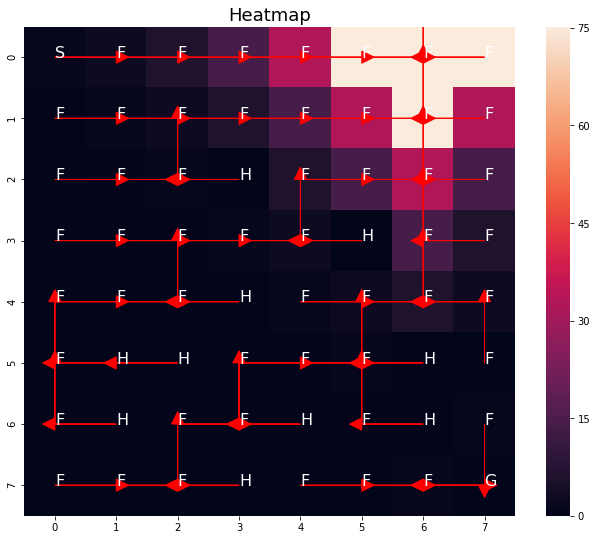

In [42]:
curr_env, policy, v = value_iteration(env_name='8x8', num_episodes=num_episodes, epsilon=epsilon, gamma=gamma)

print("")
print("Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)")
print("")

print("Policy:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

heatmap(policy=policy, V=v, direction=dir_mapper)

### Solution 3.2.2: Policy Iteration

In [46]:
def policy_evaluation(policy, env, epsilon, gamma):
    V = np.zeros(env.observation_space.n)
    V[-1] = 1
    while True:
        delta = 0

        for s in range(env.observation_space.n):
            A = get_action_values(env, s, gamma)
            best_value = np.max(A)
            delta = max(delta, np.abs(best_value - V[s]))
            V[s] = best_value

        if delta < epsilon:
            break
    return(np.array(V))

In [47]:
def policy_improvement(env_name, epsilon, gamma):
    
    env = set_environment(env_name)
    
    policy = np.ones([env.observation_space.n, env.action_space.n]) / 2
    
    while True:
        V = policy_evaluation(policy, env, epsilon, gamma)
        
        policy_stable = True
        
        for s in range(env.observation_space.n):
            current_action = np.argmax(policy[s])
            A = get_action_values(env, s, gamma)
            best_action = np.argmax(A)
            
            if current_action != best_action:
                policy_stable = False
            policy[s] = np.eye(env.action_space.n)[best_action]
        
        if policy_stable:
            break
        
    policy = np.reshape(np.argmax(policy, axis=1), (env.env.nrow, env.env.ncol))
    V = V.reshape(env.env.nrow, env.env.ncol)
    
    return(env, policy, V)

Environment set to:

SFFF
FHFH
FFFH
HFFG

Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)

Policy:
[[1 2 1 2]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]

Value Function:
[[0.28242954 0.22876792 0.34867844 0.25418658]
 [0.43046721 0.         0.531441   0.        ]
 [0.4782969  0.729      0.81       0.        ]
 [0.         0.81       1.9        0.        ]]



(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3f889b518>)

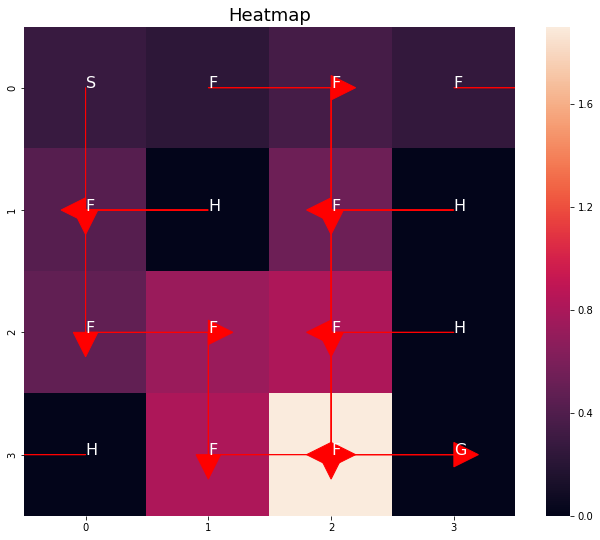

In [48]:
num_episodes = 1000
epsilon = 0.0001
gamma = 0.9
dir_mapper = {0: (-1, 0), 1:(0,1), 2: (1,0), 3: (0,-1)}

curr_env, policy, v = policy_improvement(env_name='4x4', epsilon=epsilon, gamma=gamma)

print("")
print("Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)")
print("")

print("Policy:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

heatmap(policy=policy, V=v, direction=dir_mapper)

Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)

Policy:
[[1 1 1 1 1 1 1 1]
 [1 1 1 2 1 1 1 1]
 [1 1 1 0 1 2 1 1]
 [1 1 1 2 1 0 1 1]
 [1 2 0 0 1 1 2 1]
 [1 0 0 1 2 1 0 1]
 [1 0 1 0 0 1 0 1]
 [2 2 1 0 2 2 2 0]]

Value Function:
[[0.00273893 0.00304325 0.00338139 0.0037571  0.00417456 0.0046384
  0.00515378 0.00572642]
 [0.00636269 0.00706965 0.00785517 0.00417456 0.00969774 0.01077526
  0.01197252 0.01330279]
 [0.01478088 0.0164232  0.018248   0.         0.0225284  0.01197252
  0.02781284 0.03090315]
 [0.03433684 0.03815204 0.04239116 0.0225284  0.05233476 0.
  0.06461082 0.0717898 ]
 [0.07976644 0.04239116 0.03815204 0.         0.12157665 0.13508517
  0.0717898  0.16677182]
 [0.18530202 0.         0.         0.25418658 0.13508517 0.3138106
  0.         0.38742049]
 [0.43046721 0.         0.531441   0.22876792 0.         0.729
  0.         1.9       ]
 [0.4782969  0.531441   0.531441   0.       

(<Figure size 792x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff3f89bf630>)

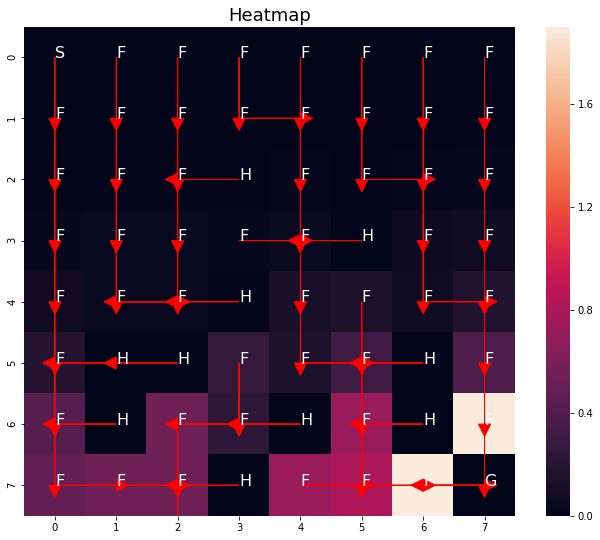

In [49]:
curr_env, policy, v = policy_improvement(env_name='8x8', epsilon=epsilon, gamma=gamma)

print("")
print("Action Legend: (0=Left, 1=Down, 2=Right, 3=Up)")
print("")

print("Policy:")
print(policy)
print("")

print("Value Function:")
print(v)
print("")

heatmap(policy=policy, V=v, direction=dir_mapper)

### Solution 3.2.3

Environment set to:

SFFF
FHFH
FFFH
HFFG
Environment set to:

SFFF
FHFH
FFFH
HFFG
Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Environment set to:

SFFF
FHFH
FFFH
HFFG
Environment set to:

SFFF
FHFH
FFFH
HFFG
Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Environment set to:

SFFF
FHFH
FFFH
HFFG
Environment set to:

SFFF
FHFH
FFFH
HFFG
Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Environment set to:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


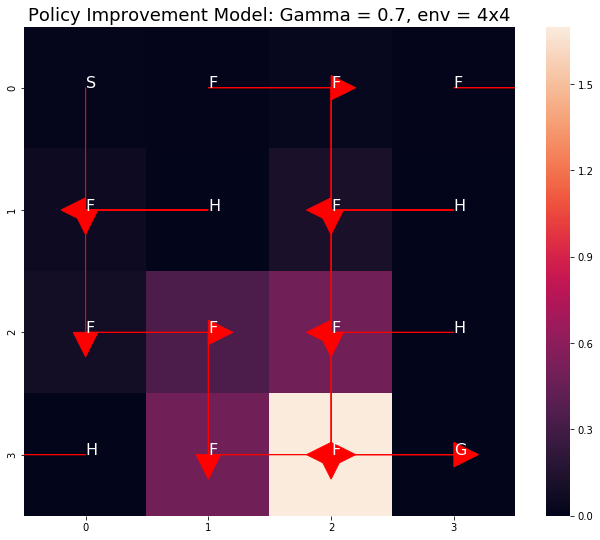

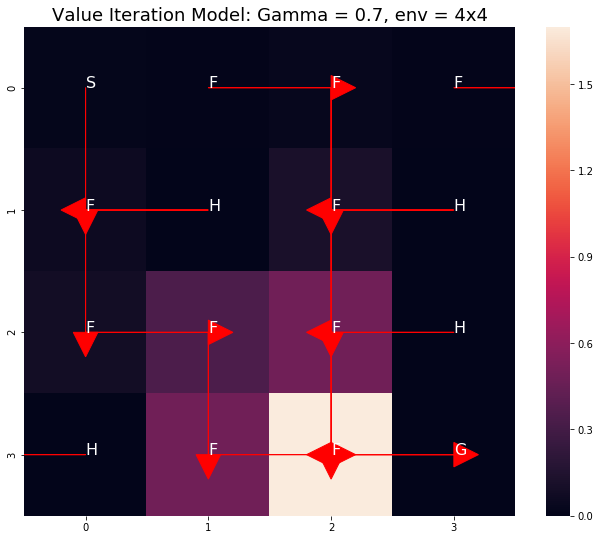

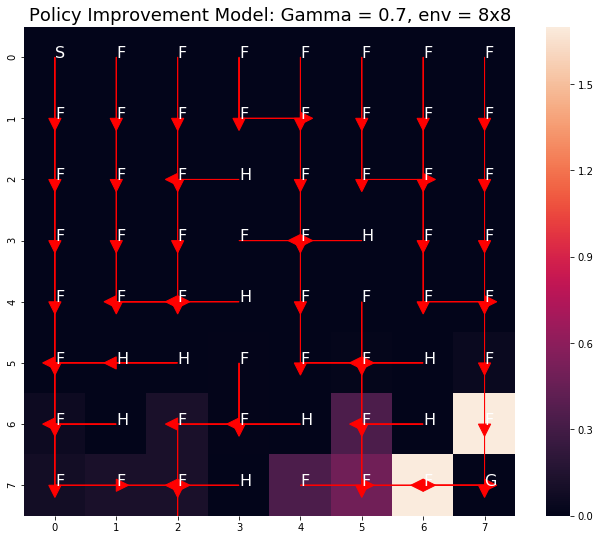

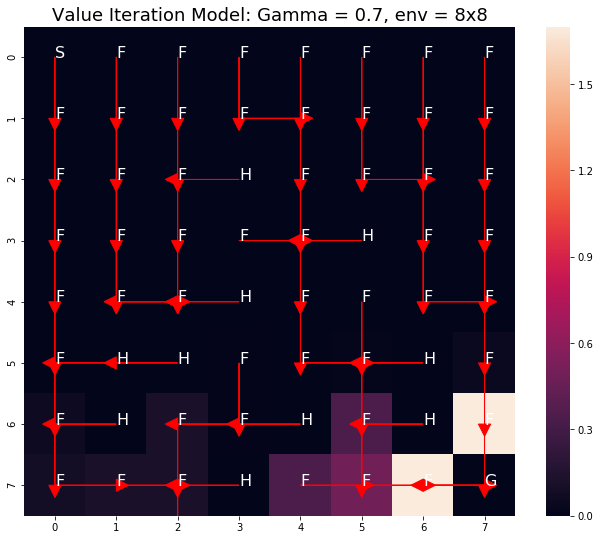

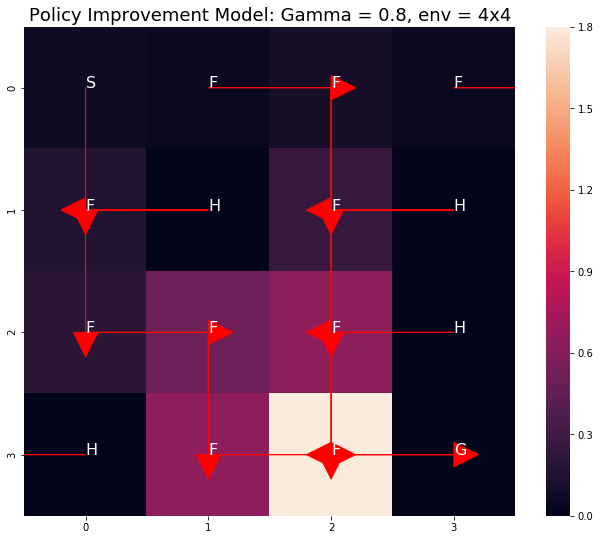

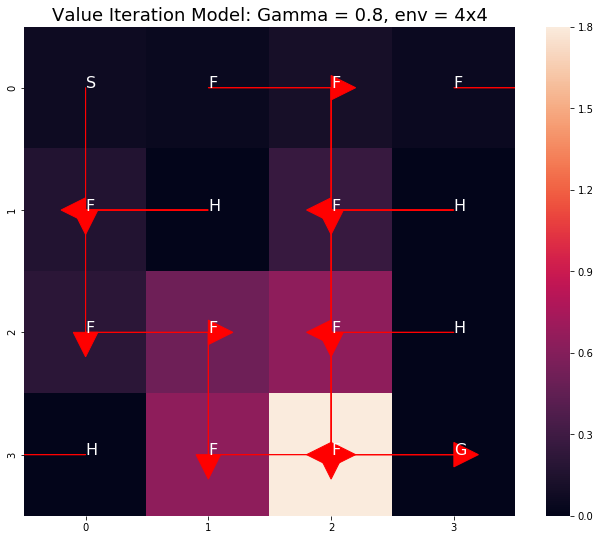

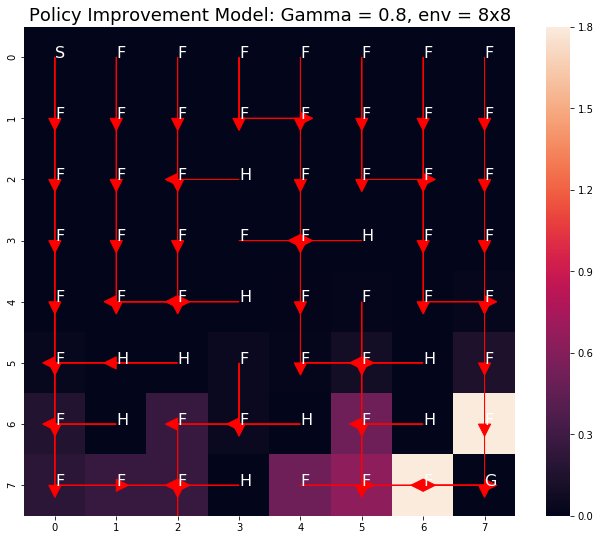

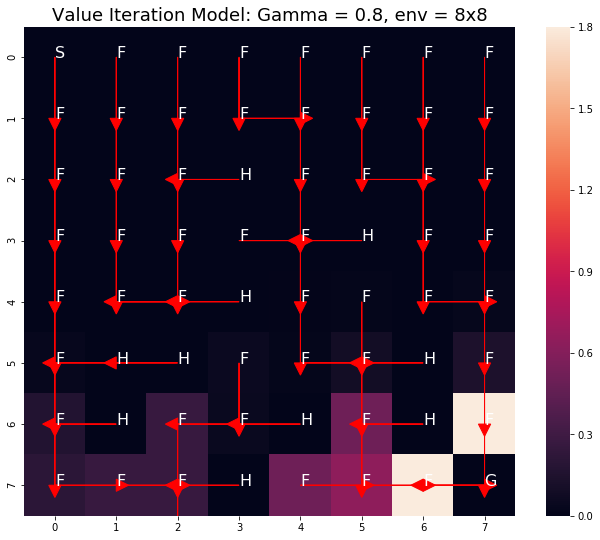

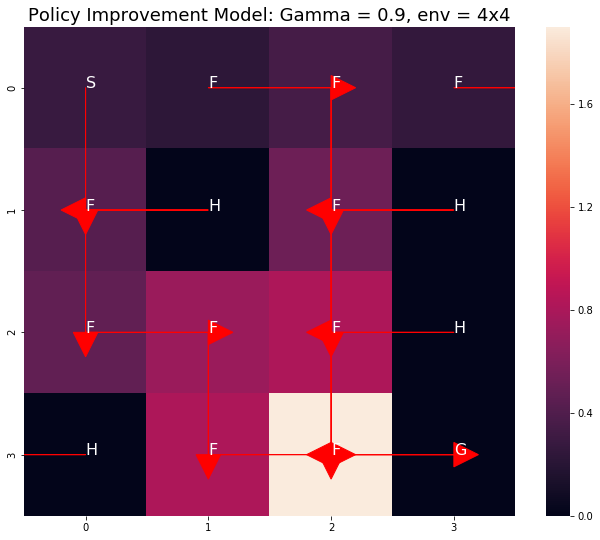

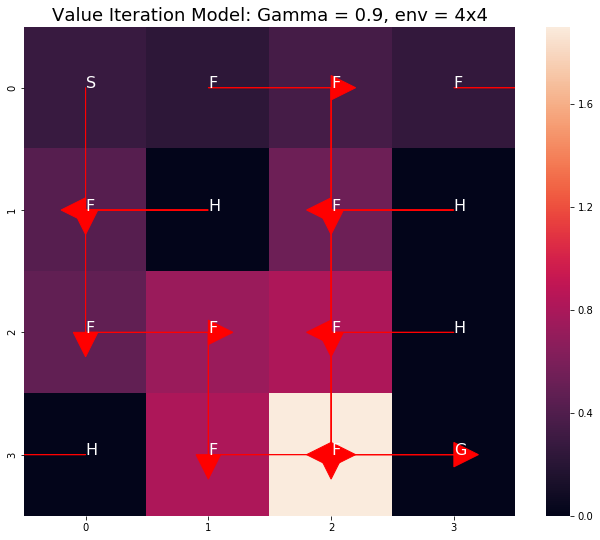

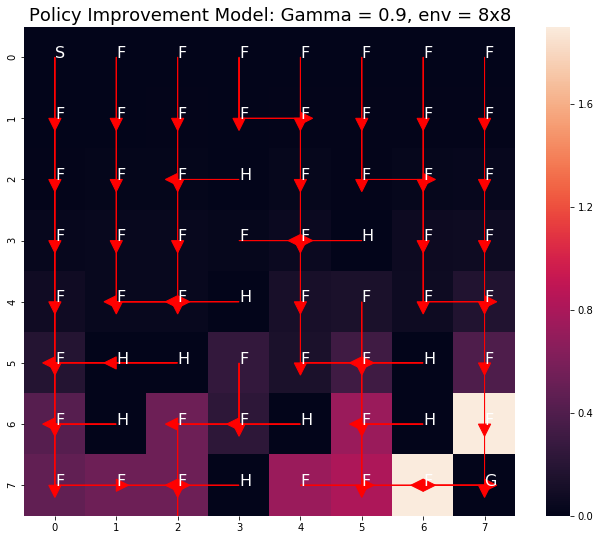

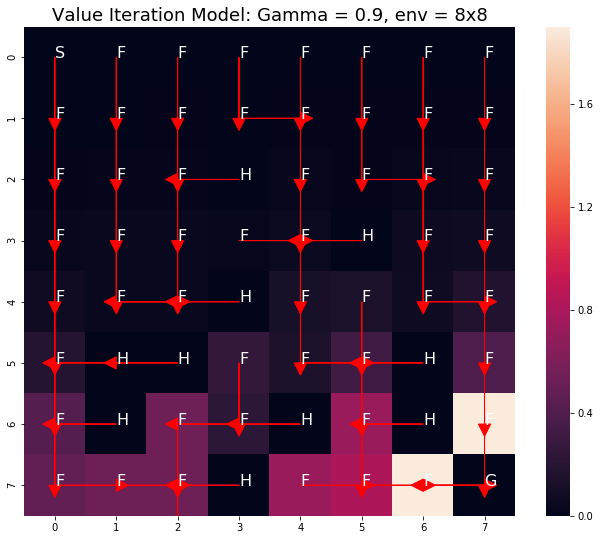

In [50]:
gamma_ls = [0.7,0.8,0.9]
env_names_ls = ['4x4', '8x8']
dir_mapper = {0: (-1, 0), 1:(0,1), 2: (1,0), 3: (0,-1)}

for g in gamma_ls:
    for en in env_names_ls:
        curr_env, policy, v = policy_improvement(env_name=en, epsilon=epsilon, gamma=g)
        t = 'Policy Improvement Model: Gamma = %s, env = %s'%(g, en)
        heatmap(policy=policy, V=v, direction=dir_mapper, title=t)
        
        curr_env, policy, v = value_iteration(env_name=en, num_episodes=num_episodes, epsilon=epsilon, gamma=g)
        t = 'Value Iteration Model: Gamma = %s, env = %s'%(g, en)
        heatmap(policy=policy, V=v, direction=dir_mapper, title=t)

*your observations here* 


**3.3 Q-Learning vs SARSA [ALMOST OPTIONAL 2 pts]** 

For an in-depth understanding of Q-Learning, SARSA and their differences, it will be beneficial to read chapter 6 in this book by Sutton and Barto - http://incompleteideas.net/book/bookdraft2018mar21.pdf

1.  Explain the difference between Q-learning and SARSA in your own words. Also, differentiate between on-policy and off-policy learning and categorize these two algorithms accordingly with justification.
2. Visualization (for the following questions)
    * For each setting of model, environment and hyperparams you run, show us visualizations in a grid format that shows the learned value functions V(s) of all states, optimal policy learned. Also in each visualization plot the F,H,G state grid on the side for easy visualization. 
    * Separately, plot the moving average of rewards per episode over 100 episodes(You either get a 0 or 1 in each episode and over time near convergence, you should be getting more 1 than 0 and hence moving avg should be close to 1. 
    * Also plot the norm(L1) of change in your value function from previous episode, again as moving average over 100 episodes - essentially a proxy for the rate of change of value function.
3. We are going to experiment with $4*4$ and $8*8$ grid in this problem and implement both Q-Learning and SARSA. Each run of the model (for one setting) should be reasonably quick on a CPU and hence, we are going to run the model over a bunch of param settings. While you can start with any Qtable in practice and the algorithm is guaranteed to converge, for consistency of evaluations in this assignment, initialize your Q-table with all 0s. Let us fix the number of episodes to 2000 and the number of iterations per episode to 100 for $4*4$ grid and 20000 and 800 for $8*8$ grid for comparison consistency across results. Also fix $\gamma$ to 0.99.  Throughout this HW, we just assume that we are training the agent and it is not in a testing environment and hence, overall rewards collected across all episodes is not so important as long as we explore well and finally learn well about the environment.

    * In practice, it makes sense to not have one constant $\epsilon$ (Remember $\epsilon$- greedy) and $\alpha$ throughout the entire training. Think about the impact of the exploration coefficient $\epsilon$ and the TD-Learning parameter $\alpha$ and suggest with justification, how you would choose and change these parameters as the agent starts learning in the environment. Experiment with different (2 each - one good and bad schedule. For example, one schedule that does exploration sufficiently as appropriate and another schedule that does not do exploration well.) $\epsilon$ (Remember $\epsilon$- greedy) and $\alpha$ schedules with a qualitative justification of the choice and proceed to discuss the differences you observe between them.
  
    * In a good hyperparam setting, we expect you to converge to the perfect optimal decision and rewards of close to 1(moving avg. plot) in all cells in the $4*4$ grid. For the $8*8$ grid and good $\epsilon. \gamma$, we expect to see the right policy decision in about atleast 40+ non-absorbing(not H or G) states. We also expect the reward(moving avg plot) to surpass 0.8. In sub-optimal hyperparam settings(which you are going to implement and discuss in the next point), we expect to see comparatively worse results. Report the number of states in which your policy matches the optimal policy and please explain why it is hard (not impossible) to get the optimal policy in all 53 non-absorbing states. <b>KUDOS TO THOSE THAT GOT THE LEARNED POLICY TO BE FULLY OPTIMAL</b> (Hint:"You dont know the things that you dont seek")
       
    * Demonstrate and discuss whether you obtained similar value function and policy estimates from the value and policy iteration solutions.
    
    * For the $8*8$ grid, choose one algo and hyperparam setting and try implementing with a lower $\gamma$ ,something like 0.6 and report what you observe (For this question, you do not need to show visualizations/plots, just a discussion should suffice).
    
    * In this setup, does Q-Learning and SARSA produce different results - Justify ? Can you explain and/or imagine circumstances(characteristics of your MDP world) under which both produce a.) similar and b.) different results?
    
<b>Overall deliverable</b> - 3 plots (policy+ V visualization, rewards, change in L1 norm of V) per exercise $*$ 2 algos $*$ 2 environments $*$ 4(2 each for $\epsilon, \gamma$) learning schedules- named appropriately to identify easily, along with a discussion wherever appropriate. 

<b> Note </b> - Even though there are a lot of experiments here, each experiment runs pretty fast the non-plotting code entails just 20 odd lines for both Q-learning and SARSA put together. Since there are multiple discussion points, please give some title (in bold) to each of your discussions so that it is easy to connect what discussion points we are talking about. Title all your plots with appropriate naming along with specifying all hyperparams needed to understand the plot without looking at the code.



